# Implementation of: A Bandit Approach to Multiple Testing with False Discovery Control
By Kevin Jamieson, Lalit Jain

## User Inputs

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Number of arms
n = 5

# Variance
variance = 0.5

# Acquisition function
#acq_func = "UCB1" #Used in paper
#acq_func = "d-PAC" #Confidence interval from [25] Theorem 8
acq_func = "UCB1_Normal"

# Sample Budget
B = 600

# Sampling method
#sample_method = "Uniform"
sample_method = "Adaptive"

# Threshold for prediction
mean_threshold = 0.5

# False Discovery Rate
delta = 0.05
d_dash = False

# TPR
TPR = True

# Coefficient in front of confidence function
c = 4

# Initial sampling
initial_loop = 2

# Visualise plots
visualise = True

# Plot out every 'how  many' iterations
plot_n = 100

### Plotting confidence bound reduction over number of arm pulls

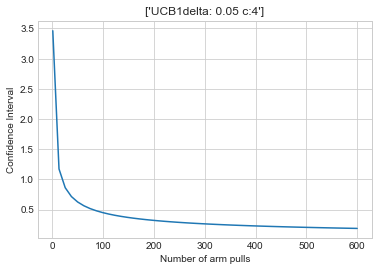

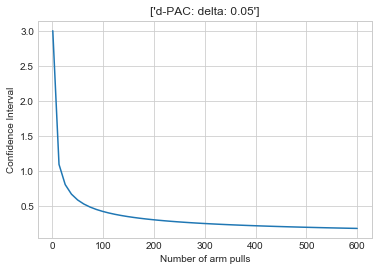

In [12]:
#delta_dash = delta
if d_dash == True:
    delta_dash = delta/(6.4*np.log(36/delta))
else:
    delta_dash = delta
t = np.linspace(1,B)

for acq in ["UCB1","d-PAC"]:
    if acq == "UCB1":
        y = np.sqrt((c*np.log(np.log2(2*t)/delta))/t)
        plt.plot(t,y)
        plt.title(["UCB1" + "delta: " +str(delta) + " c:" + str(c)])
        plt.xlabel("Number of arm pulls")
        plt.ylabel("Confidence Interval")
        plt.show()
    elif acq == "d-PAC":
        e = np.exp(1)
        val = 2*np.log(1/delta) + 6*np.log(np.log(1/delta)) + 3*np.log(np.log(e*t/2))
        y = np.sqrt(val/t)
        plt.plot(t,y)
        plt.title(["d-PAC: " + "delta: " +str(delta)])
        plt.xlabel("Number of arm pulls")
        plt.ylabel("Confidence Interval")
        plt.show()

## Set up Code

In [13]:
# CLASS: BANDIT to store information about each bandit in the game
class Bandit:

    def __init__(self,n,bandit_number):

            self.true_mean = (bandit_number)/n
            self.true_variance = variance

            self.sample_mean = 0
            self.bandit_trial = 0
            
            self.q = 0


    def Sample_Bandit(self):
        
        # Update number of trials of bandit
        self.bandit_trial += 1

        # Pull arm and return reward
        reward = np.random.normal(self.true_mean, self.true_variance,1)

        # Update bandit sample mean
        self.sample_mean = self.sample_mean + (reward - self.sample_mean)/self.bandit_trial
        
        # Updated sum of squared rewards
        self.q = self.q + reward**2

        return reward


# CLASS: GAME to store results of game (made up of bandits)
class Game:

    def __init__(self,n,acq_func,delta,TPR):
        
        self.n = n
        self.total_trials = 0
        self.St = {}
        
        if TPR == True:
            e_t = 1
            v_t = 1
            
            
        self.bandit_dictionary = {}

        # Create each bandit 
        for i in range(self.n):
            self.bandit_dictionary[str(i+1)] = {}
            self.bandit_dictionary[str(i+1)] = Bandit(self.n,i+1)
        
        # Conduct and initial sample from each bandit
        
        for il in range(initial_loop):
            for i in range(self.n):
                self.bandit_dictionary[str(i+1)].Sample_Bandit()
                self.total_trials += 1
            
        #Plot distribution
        
        #print('trial' + str(self.total_trials))
        y = np.zeros([1,self.n]).reshape(-1,)
        no_pulls = np.zeros([1,self.n]).reshape(-1,)
        for i in range(self.n):
            y[i] = self.bandit_dictionary[str(i+1)].sample_mean
            no_pulls[i] = self.bandit_dictionary[str(i+1)].bandit_trial 

        print('trial: ' + str(self.total_trials))
        print('Number of arm pulls: ' + str(no_pulls))
        if visualise == True:
            plt = Game.Visualise(self,y,delta,mean_threshold,acq_func)
            plt.show()

        # Sample according to sampling method
        if sample_method == "Uniform":
            times = int(B/self.n)
            for j in range(times):
                for i in range(self.n):
                    self.bandit_dictionary[str(i+1)].Sample_Bandit()
                    self.total_trials += 1
        else:
            while self.total_trials < B:
                
                #Select next arm to sample
                acq_value = -1000
                arm_next = 1
                
                for i in range(self.n):
                    if ((i+1) not in self.St):

                        bandit_info = self.bandit_dictionary[str(i+1)]
                        
                        I =  bandit_info.sample_mean + Game.Confidence_Interval(self,bandit_info,delta/e_t,c,acq_func)
                        if I > acq_value:
                            acq_value = I
                            arm_next = i+1
                
                # Pull the selected arm
                self.bandit_dictionary[str(arm_next)].Sample_Bandit()
                self.total_trials += 1
                
                # Update St
                self = Game.Update_St(self,delta,acq_func)
                
                #Plot distribution
                if self.total_trials % plot_n == 0:
                    print('trial: ' + str(self.total_trials))
                    print('Arm above threshold: ' + str(self.St))
                    y = np.zeros([1,self.n]).reshape(-1,)
                    no_pulls = np.zeros([1,self.n]).reshape(-1,)
                    for i in range(self.n):
                        y[i] = self.bandit_dictionary[str(i+1)].sample_mean
                        no_pulls[i] = self.bandit_dictionary[str(i+1)].bandit_trial 

                    print('Number of arm pulls: ' + str(no_pulls))
                    if visualise == True:
                        plt = Game.Visualise(self,y,delta,mean_threshold,acq_func)
                        plt.show()
                    
    
    def Visualise(self,mean,delta,mu_threshold,acq_func):
    
        plt.style.use('seaborn-whitegrid')
        x = np.linspace(1,self.n,self.n)
        color = ['g','r','b','k','y','m']
        ranges = np.linspace(n,0,n)
        
        if d_dash == True:
            delta_dash = delta/(6.4*np.log(36/delta))
        else:
            delta_dash = delta
        
        dy = np.zeros([1,self.n]).reshape(-1,)
        for k in ranges:
            k = int(k)
            for i in range(self.n):
                dy[i] = Game.Confidence_Interval(self,self.bandit_dictionary[str(i+1)],delta_dash*(k+1)/self.n,c,acq_func)
            
            #plt.errorbar(x, mean, yerr=dy, fmt='o', color='black',ecolor=color[k], elinewidth=20-3*k, capsize=20-3*k)
            plt.errorbar(x, mean, yerr=dy, fmt='o', color='black',ecolor=color[k], elinewidth=3*k+1, capsize=3*k+1)

        plt.axhline(mu_threshold)

        return plt
    
    def Confidence_Interval(self,bandit_info,d,c,acq_func):
        
        t = bandit_info.bandit_trial
        mean = bandit_info.sample_mean
        
        if acq_func == "UCB1":
            Confidence_value = np.sqrt((c*np.log(np.log2(2*t)/d))/(t))
            
        elif acq_func == "d-PAC":
            e = np.exp(1)
            val = 2*np.log(1/d) + 6*np.log(np.log(1/d)) + 3*np.log(np.log(e*t/2))
            Confidence_value = np.sqrt(val/t)
            
        elif acq_func == "UCB1_Normal":
            
            q = bandit_info.q
            term1 = (np.sum(q) - t*mean**2)/(t-1)
            term2 = np.log(self.total_trials - 1)/t
            Confidence_value = np.sqrt(16*term1*term2)
        
        return Confidence_value
    
    def Update_St(self, delta,acq_func):
        
        # Apply Benjamini-Hochberg
        if d_dash == True:
            delta_dash = delta/(6.4*np.log(36/delta))
        else:
            delta_dash = delta
 
        # Discover St set
        K_LENGTH = 0
        for k in range(self.n):
            
            k_list = list()
            
            for i in range(self.n):
            
                bandit_info = self.bandit_dictionary[str(i+1)]
 
                confidence = Game.Confidence_Interval(self,bandit_info,delta_dash*(k+1)/self.n,c,acq_func)
                I = bandit_info.sample_mean - confidence
                
                    
                if (I >= mean_threshold):
                    k_list.append((i+1))

            len_k = len(k_list)
            if (len_k > K_LENGTH) and (len_k >= (k+1)):
                self.St = k_list
                #print(k)
            
        return self

## Run Experiment

trial: 10
Number of arm pulls: [2. 2. 2. 2. 2.]


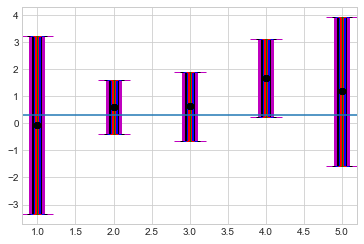

trial: 100
Arm above threshold: [4, 5]
Number of arm pulls: [10. 18. 10. 53.  9.]


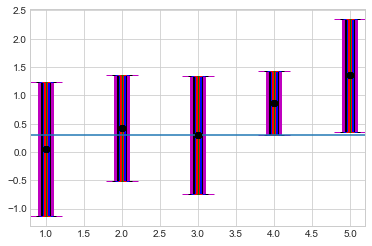

trial: 200
Arm above threshold: [4, 5]
Number of arm pulls: [14. 38. 77. 61. 10.]


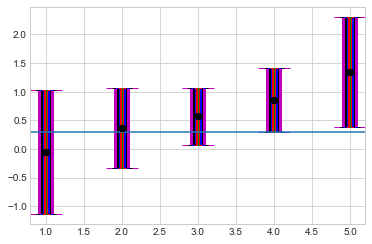

trial: 300
Arm above threshold: [4, 5]
Number of arm pulls: [ 17.  64. 143.  66.  10.]


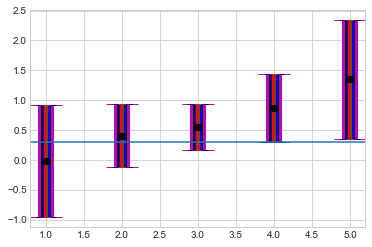

trial: 400
Arm above threshold: [4, 5]
Number of arm pulls: [ 23.  87. 211.  69.  10.]


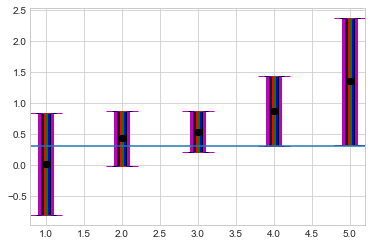

trial: 500
Arm above threshold: [4, 5]
Number of arm pulls: [ 25.  98. 297.  70.  10.]


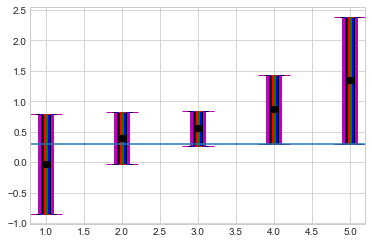

trial: 600
Arm above threshold: [4, 5]
Number of arm pulls: [ 25. 128. 357.  71.  19.]


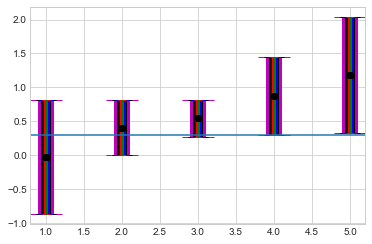

In [14]:
G = Game(n,acq_func,delta,TPR)

## Print out final arm stats

In [15]:
print("True and Sample Mean for each Arm")
print("Number of times each arm was pulled")
for i in range(n):
    print("")
    print("Arm: " + str(i+1))
    print('True mean:', G.bandit_dictionary[str(i+1)].true_mean)
    print('Sample mean:', G.bandit_dictionary[str(i+1)].sample_mean)
    print('Trials:', G.bandit_dictionary[str(i+1)].bandit_trial)
    

True and Sample Mean for each Arm
Number of times each arm was pulled

Arm: 1
True mean: 0.2
Sample mean: [-0.02914228]
Trials: 25

Arm: 2
True mean: 0.4
Sample mean: [0.40772524]
Trials: 128

Arm: 3
True mean: 0.6
Sample mean: [0.54322314]
Trials: 357

Arm: 4
True mean: 0.8
Sample mean: [0.87128368]
Trials: 71

Arm: 5
True mean: 1.0
Sample mean: [1.18792691]
Trials: 19


In [16]:
print("Arm's that are above threshold:")
print(G.St)

Arm's that are above threshold:
[4, 5]
